# Comparing Correlation Coefficient and Sample Equivalence Index with Simulated Scenarious

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The notebook will be using simulated data but the reference data comes from the processed and subetted tables from the spiked-in dataset in `./data/processed/samples` folder. I will describe the each scenario I want to test and simulate either one or both of the samples to test the performance of correlation and sample equivalence index.

**Notebook Summary:**

In this notebook I will design and test the performance of correlation coefficient and sample equivalence index (SEI) in different scenarios. While SEI from `questvar` is not exactly the same as correlation coefficient metric, they are both used to measure the similarity between two variables. I will use the scenarious designed in this notebook to measure the performance of these two metrics.

## Setup Notebook

This part is a standard for my notebooks, where I import the all used libraries, set the design of the notebook, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os
import sys
import feather
import warnings
from multiprocessing import Pool # Multiprocessing

import numpy as np 
import pandas as pd 

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 

sys.path.append('../')
# Custom functions
from questvar import plots, utils, test
warnings.filterwarnings('ignore')

nbStartTime = utils.getTime()

### Notebook's Styling

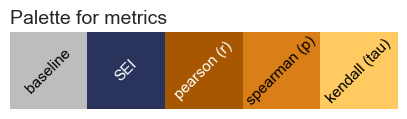

In [2]:
### Notebook Configuration

# Set random seed
# np.random.seed(42) # Remove this line if you want to have random results

# Colors
metric_colors = {
    "baseline": "#BDBDBD",
    "SEI": "#29335c",
    "pearson (r)": "#a75700",
    "spearman (p)": "#da7f17",
    "kendall (tau)": "#ffca61"
}

## Configure some general styling

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    # palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)


## Color Palettes used

# Metric colors
plots.color_palette(
    metric_colors,
    name = "metrics"
)

### Data and Result Paths

The data and figure related paths are defined here. It will point to the input file paths as well as notebook specific output paths to distinguish between similar application result related notebooks. The `notebook_name` variable contains the specific identifier that will be used to create the output folder for this notebook. For the output the data `data/results/{notebook_name}/` will be used and for the figures `figures/{notebook_name}/` will be used. 

Similar to other notebooks the notebook's figure path will contain subfolders specific to the formats user selected to save the figures in for instance if `['png', 'pdf']` is selected then there will be two subfolders `png` and `pdf` in the `figures/{notebook_name}/` saving the figures in png and pdf formats respectively.

In [3]:
# Establish notebook specific paths
notebook_name = "SimComparison"

data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Figures folder
input_path = f"{data_path}processed/samples/"
output_path = f"{data_path}results/{notebook_name}/"
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)

# Check if the paths exist
if not os.path.exists(input_path):
    raise ValueError(
        f"the input folder doesn't exists, run the notebook '01-Prepare_Input_Data.ipynb' first"
    )

# Create folders for various outputs
for i in [output_path]:
    if not os.path.exists(i):
        os.makedirs(i)   

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = fig_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Setup the Data

For analysis, I will use two samples `1-06` and `1-25` from the spiked-in dataset. The data is already processed and subsetted in the `./data/processed/samples` folder. I will load the data and subset the data to the samples I want to use for analysis.

### 1-06 Sample

In the spiked-in dataset this sample has the highest number of E.coli peptides spiked in. This will be the main sample for the analysis, since it has more proteins quantified overall. 

In [4]:
# Read in the data
S1 = "1-06"
S1_data = feather.read_dataframe(input_path + S1 + ".feather")
S1_data.columns = [S1 + "_" + str(x) for x in range(1, S1_data.shape[1]+1)]
s1_cols = S1_data.columns
s1_col_dict = {x:"S1" for x in s1_cols}
print(f"Read in {S1} data, shape: {S1_data.shape}")
S1_data.head()

Read in 1-06 data, shape: (5389, 23)


,1-06_1,1-06_2,1-06_3,1-06_4,1-06_5,1-06_6,1-06_7,1-06_8,1-06_9,1-06_10,1-06_11,1-06_12,1-06_13,1-06_14,1-06_15,1-06_16,1-06_17,1-06_18,1-06_19,1-06_20,1-06_21,1-06_22,1-06_23
Q86U42,506318.9739,543113.2487,445348.6625,508487.2738,511737.1955,571885.0932,507285.1472,492400.1750,392216.8403,627397.2261,512410.4286,1455567.5790,474381.4433,561736.8644,390371.5268,516029.5265,561470.9722,537915.1707,529126.3246,578867.3645,476894.6795,418973.9113,509490.8268
P37108,898993.1767,926475.0344,779352.4682,915210.0106,949845.1089,1083606.0889,541074.8500,740986.9593,751875.6986,784325.9671,838760.0197,1243387.3695,799527.0152,637546.9023,539831.1308,763614.2714,863317.3884,1057359.3975,781240.0898,793179.9558,952326.7184,722270.4750,903949.7069
Q96JP5,361407.6293,390284.0107,420619.5788,399276.8189,393757.0148,337906.0935,246724.4268,401921.3447,278077.6930,371504.2974,387909.7707,823581.1740,392545.1085,338218.6930,281525.6191,371369.4064,360951.5606,367604.4697,340458.2120,385941.3061,333588.2935,385200.1859,345125.5870
Q8N697,920834.0000,612875.0000,463855.0000,387322.0000,707871.0000,443971.0000,427263.0000,529735.9524,413949.0000,529735.9524,428282.0000,509009.0000,718818.0000,447387.0000,697278.0000,668286.0000,457091.0000,644856.0000,203422.0000,659524.0000,349385.0000,465406.0000,497771.0000
O75822,503476.2175,457396.3332,539600.7011,461392.5282,454764.2379,511720.6153,428131.0396,551994.1797,435108.4593,560902.3976,510640.3993,1080424.2962,453743.5668,399463.1396,448645.7216,433481.7454,438830.0462,486301.5556,407213.7059,487205.9137,529161.3565,429783.3607,513552.8636


### 1-25 Sample

This sample has the lowest number of E.coli peptides spiked in. This will be used to create a first look at the data and the metrics, and won't be used as the base for the simulation later one. 

In [5]:
# Read in the data
S2 = "1-25"
S2_data = feather.read_dataframe(input_path + S2 + ".feather")
S2_data.columns = [S2 + "_" + str(x) for x in range(1, S2_data.shape[1]+1)]
s2_cols = S2_data.columns
s2_col_dict = {x:"S2" for x in s2_cols}
print(f"Read in {S2} data, shape: {S2_data.shape}")
S2_data.head()

Read in 1-25 data, shape: (5389, 23)


,1-25_1,1-25_2,1-25_3,1-25_4,1-25_5,1-25_6,1-25_7,1-25_8,1-25_9,1-25_10,1-25_11,1-25_12,1-25_13,1-25_14,1-25_15,1-25_16,1-25_17,1-25_18,1-25_19,1-25_20,1-25_21,1-25_22,1-25_23
Q86U42,585229.0835,551206.9243,549250.7723,613839.1230,478445.1170,575464.4724,404524.1058,723671.6111,502216.2053,576384.1789,721606.3284,590432.9555,527667.9454,526558.3873,558609.9396,650956.9406,630133.0545,612365.1598,533792.7704,393075.8087,629678.3176,636899.7977,565708.7885
P37108,726212.4053,834385.6676,562562.6101,786967.1018,783455.8872,743385.7820,870689.4457,1077785.3304,1004297.7550,777432.0492,599775.6774,734540.2992,909634.9909,723311.8939,1013371.7146,705382.1843,874476.1424,739282.7117,957612.5027,744393.1317,787372.9460,761241.3018,784132.0192
Q96JP5,223641.0512,345542.6200,210865.2951,438820.8022,332376.6977,422750.0379,262649.5066,485595.9569,346770.2705,310267.6673,391632.9878,331525.2139,363909.5042,339585.3445,352808.8997,272149.8259,343031.3260,220737.2582,219713.7280,518332.5927,229632.3478,325757.9322,331277.1303
Q8N697,436200.0000,575635.0000,621270.0000,462924.2105,634370.0000,580020.0000,583005.0000,298435.0000,403102.0000,510455.0000,230607.0000,622490.0000,401139.0000,489384.0000,338478.0000,462924.2105,111545.0000,368493.0000,462924.2105,653873.0000,370848.0000,566211.0000,462924.2105
O75822,529361.2223,448537.6740,423621.5227,649039.9202,457853.0122,396675.2760,481554.6369,565435.4732,619813.2000,427464.9521,394526.9257,495964.5011,526744.7501,544098.2829,459563.4854,427653.5124,521920.9921,469837.3194,445990.6472,449050.0367,461258.8501,530116.6669,484931.9408


### Protein Info Data

This will be used only to calculate the observable ground truth for the initial comparison between two real samples (1-06 and 1-25).


$$
\text{Observable\_ground\_truth} = \frac{\text{human\_protein\_quantified\_in\_both\_samples}}{\text{total\_proteins\_quantified\_in\_both\_samples}} 
$$


The rational behind it is that both sample's protein quantification should be the same, and the spike-in ratios should be the only difference between the two samples, hence the similarity between two samples are ratio of human protein quantified in both samples to the total number of proteins quantified in both samples.

In [6]:
protein_info_data = feather.read_dataframe(
    f"{data_path}processed/protein_info_data.feather"
)
print(f"Data shape: {protein_info_data.shape}")
protein_info_data.head()

Data shape: (5389, 5)


,entry,entryName,geneName,sequenceLength,organism
0,A0A075B6H9,LV469_HUMAN,IGLV4-69,119,H.Sapiens
1,A0A075B6I9,LV746_HUMAN,IGLV7-46,117,H.Sapiens
2,A0A075B6K4,LV310_HUMAN,IGLV3-10,115,H.Sapiens
3,A0A075B6R9,KVD24_HUMAN,IGKV2D-24,120,H.Sapiens
4,A0A0A0MS15,HV349_HUMAN,IGHV3-49,119,H.Sapiens


In [7]:
if not (S1_data.index == S2_data.index).all():
    raise ValueError(
        """The two dataframes do not share the same index!"""
    )
else:
    print("Dataframes have the same index!")
    # Create a dictionary of column names
    col_dict = {**s1_col_dict, **s2_col_dict}

# Combine data and drop missing values
data = pd.concat([S1_data, S2_data], axis=1).dropna()
data = np.log2(data)

# Find the observable ground truth similarity

baseline = protein_info_data.set_index("entry").loc[
    data.index, 
    'organism'
].value_counts(
    normalize=True
)["H.Sapiens"]
print(f"Comparison between {S1} and {S2} data:")
print(f"Observable similarity: {baseline:.2f}")

Dataframes have the same index!
Comparison between 1-06 and 1-25 data:
Observable similarity: 0.90


## Looking at Real Data and Metrics

First I will compare the two real samples with correlation and SEI. I will use the `questvar` package to calculate the SEI and `corr()` function from `pandas` to calculate the correlation coefficients. Both set of metrics will be calculted on the log2 scaled data.

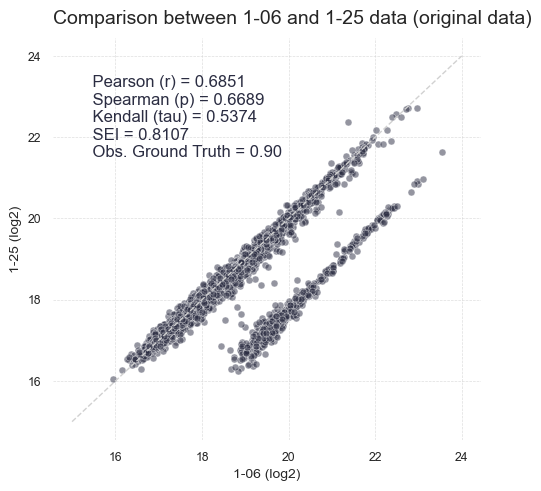

In [8]:
plots.scatterplot_annotated_comparison(
    data = data,
    s1_cols = s1_cols,
    s2_cols = s2_cols,
    baseline = baseline,
    # Used to calculate the equivalence percent value
    pThr = 0.05,
    eqThr = 0.5,

    figsize = (5, 5),
    xlabel = f"{S1} (log2)",
    ylabel = f"{S2} (log2)",
    title = f"Comparison between {S1} and {S2} data (original data)",
    title_fontsize=14,
    point_size = 25,
    save = True,
    filepath = fig_path,
    fileformat = figure_formats,
    filename = "RealData_RealReplicates_Correlation_Scatter",
    dont_show = False
)

With the equivalence boundary used here is (-0.5, 0.5) the SEI is bit further than baseline but captures the similarity better than correlation metrics. The SEI is calculated as;

`sample equivalence index (SEI) = num_eq_prots / num_tested_prots`

However it can be defined as `num_eq_prots / num_significant_prots`, which might be better metric to test the observeable baseline, since the lower precision will create uncertainty in the significance of the proteins.

Another thing to mention here is that the equivalence boundary is important to decide what you call equivalent or not. In the example above I've called -.5 to .5 which is not small or large, but might be necessary to increase if the technical variation in the data is high. However if you increase the equivalence boundaries the difference boundry should increase as well and never be less than the equivalence boundary.

### Effect of Equivalence Boundary 

Let's see how the equivalence boundary effects the SEI. I will use the same data but change the equivalence boundary from 0.01 to 2.5.

> Note: I am using non-corrected p-values here, since the correction is not necessary for the simulated data.

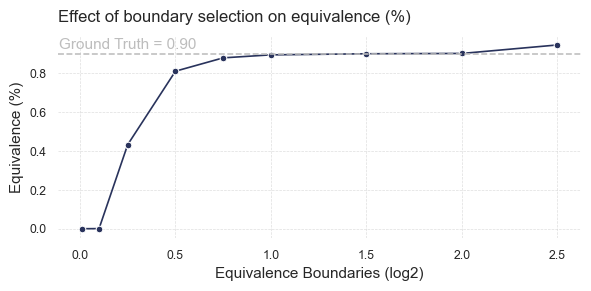

In [9]:
eq_res = []
bndrs = [0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5]
for i in bndrs:
    eq_res.append(
        test.equivalence_percent(
            data = data,
            s1_cols = s1_cols,
            s2_cols = s2_cols,
            pThr = 0.05,
            eqThr = i,
        )
    )

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)

# Plot the data
sns.lineplot(
    x = bndrs,
    y = eq_res,
    color = metric_colors["SEI"],
    ax = ax, 
    marker = "o"
)

# Add baseline line
ax.axhline(
    y = baseline,
    color = metric_colors["baseline"],
    linestyle = "--",
    linewidth = 1.15
)

# Annotate the baseline line
ax.annotate(
    f"Ground Truth = {baseline:.2f}",
    xy = (0.25, baseline),
    xytext = (0.25, baseline + 0.01),
    color = metric_colors["baseline"],
    fontsize = 11,
    ha = "center",
    va = "bottom",
)

# Add grid
ax.grid(
    axis = "both",
    color = "lightgray",
    alpha = 0.75,
    linestyle = "--",
    linewidth = 0.5
)

# Set axis labels
ax.set_xlabel(
    "Equivalence Boundaries (log2)",
    fontsize = 11
)

ax.set_ylabel(
    "Equivalence (%)",
    fontsize = 11
)

ax.set_title(
    "Effect of boundary selection on equivalence (%)",
    fontsize = 12,
    loc = "left",
    pad = 10,
)

sns.despine(
    left = True,
    bottom = True
)
plt.tight_layout()


# Simulated Scenarios

In its core the simulation will start with identical two samples and introducing some sort of difference to the second sample at increasing number of proteins, this way we can see how each metric responds to the increasing difference between the two samples with observeable ground truth to compare against.

The correlation coefficient is a measure of linear relationship between two variables, and the equivalence percent is a measure of how many proteins are equivalent between two samples. So correlation is used to simply check the overall pattern of the data, while equivalence percent relaying on the significantly equivalent proteins provides a more detailed and robust similarity measure between two samples.

The main rules I will use to simulate the data are;

- Will use 20 replicates to represent a sample, for some scenarios they will be identical and for some scenarios they will contain intra-sample variation, mimicking cv distribution of the real data.
- Will use 5289 proteins since that is the number of proteins quantified in the 1-06 sample
- Run simualation by introducing a difference at 250 protein intervals, starting from 0 to 5250 proteins.
- Calculate all the metrics from log2 scaled data.
- Using -0.5 to 0.5 as the equivalence boundary.
- FDR P-value correction is used to correct p-values and only fdr < 0.05 are considered significant.
- Calculation of equivalence percent is done by using the number of tested proteins as the denominator (all in this case), and the number of equivalent proteins as the numerator.

While the results will be put together in a dataframe and plotted as line plots, with the x-axis being the number of proteins with difference introduced and y-axis being the metric value. The observeable ground truth is calculated as the 1 - percent of proteins with difference introduced, since the difference is introduced to the second sample, the observeable ground truth will be 1 at the beginning and decrease diagonally.

In [10]:
# Create a simulated dataset 
pThr = 0.05
eqThr = 0.5
gap = 250
n_rep = 20
correction = "FDR"

sim_data = pd.concat(
    [
        S1_data.mean(axis=1), 
        S1_data.mean(axis=1)
    ], axis=1
).dropna()

sim_data = np.log2(sim_data)
sim_data.columns = [S1, S2]

total_proteins = sim_data.shape[0]

# Data to store all simulation results
simulation_results_data = pd.DataFrame()

# Create list of protein numbers to change in each simulation
custom_range = list(range(0, total_proteins, gap))
# Snapshot places
percentile_vals = np.percentile(custom_range, [0, 50, 100]) # Percentils
percentile_vals = [min(custom_range, key=lambda x:abs(x-y)) for y in percentile_vals]
print("Main Parameters used for the simulation scenarious:")
print(f"    pThr: {pThr}, eqThr: {eqThr}, correction: {correction}")
print(f"    Total proteins: {total_proteins}, n_rep: {n_rep}")
print(f"    Interval size: {gap}")
print(f"    Number of intervals: {total_proteins//gap}")
print(f"    Percentiles for snapshots: {percentile_vals}")
print(f"    Using middle groups for snapshots")

print()
print(f"Sample References Data: {sim_data.shape}")
sim_data.head()

Main Parameters used for the simulation scenarious:
    pThr: 0.05, eqThr: 0.5, correction: FDR
    Total proteins: 5389, n_rep: 20
    Interval size: 250
    Number of intervals: 21
    Percentiles for snapshots: [0, 2500, 5250]
    Using middle groups for snapshots

Sample References Data: (5389, 2)


,1-06,1-25
Q86U42,19.0667,19.0667
P37108,19.6761,19.6761
Q96JP5,18.5316,18.5316
Q8N697,19.0149,19.0149
O75822,18.9344,18.9344


## Scenario 1: Introducing a Fixed Fold-change Difference in One and Both Directions

In this first scenario I want to see how the performance of metrics change when I introduce a fixed fold-change difference to the second sample. I will do that in two versions, one where I introduce the difference in one direction and the other where I introduce the difference in both directions.The fixed log2 fold-change diferences will be 0.5, 2, 8.

Here are the things I am interested in seeing in this scenario:
- How the magnitude of the difference effects the metrics
- Does the direction of the difference effects the metrics, one direction vs both directions


### Initialize Iterations to Run

With the parameters to check, I've create unique iterations to run and pass it later to a function that will run the simulation and return the results.

In [11]:
results_data = pd.DataFrame()
s1_arr = sim_data[S1].values
s2_arr = sim_data[S2].values
total_proteins = s1_arr.shape[0]
s1_cols = [S1 + "_" + str(x) for x in range(1, n_rep+1)]
s2_cols = [S2 + "_" + str(x) for x in range(1, n_rep+1)]

directions = ["one", "both"]
groups = [0.25, 2, 8]
snapshot_group = 2
# custom_range
iterations = []
for i in custom_range:
    for j in directions:
        for k in groups:
            iterations.append([
                i,  # Number of proteins to change
                j,  # Direction
                k   # Fold-change
            ])

print(f"Total iterations to run: {len(iterations)}")

Total iterations to run: 132


### Running the Simulation and Plotting the Line Plot

Because I usually have to run over more than 100 simulations I will put the code that creates simulated data, runs the metrics, creates snapshots plots and creates all the results as a table into a function that can be run over multiple-cores to speed up the process.

The results will be presented as a line plot with the percentage of proteins the difference is added on the x-axis and the metric's value from 0 to 1 on the y-axis. The line plot will have 12 lines, 4 colors for each metric and 3 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

The observeable ground truth will be a diagonal line in decreaing order from 1 to 0. 

In [12]:
# The function to run over multiple-cores 
def run_simulation_one(cur_iter):
    cur_s1_arr = s1_arr.copy()
    cur_s2_arr = s2_arr.copy()
    cur_name = f"Prot-{cur_iter[0]}_Dir-{cur_iter[1]}_Grp-{cur_iter[2]}"
    # Get the number of proteins to change
    n_proteins = cur_iter[0]
    # Calculate reference similarity
    baseline = 1 - (n_proteins / total_proteins)
    # Get the direction
    cur_direction = cur_iter[1]
    # Get the fold change
    cur_group = cur_iter[2]
    
    # Get the indexes to change
    idxs = np.random.choice(
        total_proteins, 
        n_proteins, 
        replace=False
    )
    if cur_direction == "both":
        # Get the fold change values
        dir = np.random.choice(
            [-1, 1], 
            n_proteins, 
            replace=True
        )
        fc_vals = dir * (cur_group)
    else: 
        fc_vals = 1 * (cur_group)

    # Change the values
    cur_s2_arr[idxs] = cur_s2_arr[idxs] + fc_vals

    # Create a dataframe with the replicated data
    cur_data = pd.concat(
        [
            pd.DataFrame(
                np.tile(cur_s1_arr, (n_rep, 1)).T,
                columns=s1_cols
            ),
            pd.DataFrame(
                np.tile(cur_s2_arr, (n_rep, 1)).T,
                columns=s2_cols
            )
        ],
        axis=1
    )

    # Store the data at the custom moments
    if n_proteins in percentile_vals:
        if cur_group == snapshot_group:
            plots.scatterplot_annotated_comparison(
                data = cur_data,
                s1_cols = s1_cols,
                s2_cols = s2_cols,
                baseline = baseline,
                # Used to calculate the equivalence percent value
                pThr = pThr,
                eqThr = eqThr,

                figsize = (5, 5),
                xlabel = f"{S1} (log2)",
                ylabel = f"{S2} (log2)",
                title = f"Snapshot Comparison -> ({cur_name})",
                title_fontsize=14,
                point_size = 25,
                save = True,
                filepath = fig_path,
                fileformat = figure_formats,
                filename = f"FixedFC_{cur_name}_Snapshot",
                dont_show = True
            )

    # Collect and store metrics
    res = utils.collect_metrics(
        cur_data,
        cur_data.columns[:n_rep],
        cur_data.columns[n_rep:],
        pThr=pThr,
        eqThr=eqThr,
    )
    res["obs_ground_truth"] = baseline
    res["changed_prots_pct"] = n_proteins / total_proteins * 100
    res["direction"] = cur_direction
    res["group"] = cur_group
    res["simulation"] = 1

    return pd.Series(res)

# Run the simulation
with Pool(30) as p:
    results_data = p.map(run_simulation_one, iterations)

sim1_data = pd.concat(results_data, axis=1).T.sort_values(
    [
        "group", "direction", "changed_prots_pct"
    ], 
    ascending=[True, False, True]
).reset_index(drop=True)

# Save the data
sim1_data.to_csv(
    f"{output_path}Simulation1_Data.csv",
    index=False
)

# Add the sim data to the simulation results
simulation_results_data = pd.concat(
    [
        simulation_results_data,
        sim1_data
    ],
    axis=0,
    ignore_index=True
)

print(f"Simulation 1: {sim1_data.shape}")
sim1_data.head()

Simulation 1: (132, 9)


,pearson (r),spearman (p),kendall (tau),SEI,obs_ground_truth,changed_prots_pct,direction,group,simulation
0,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,one,0.2500,1
1,0.9988,0.9985,0.9876,1.0000,0.9536,4.6391,one,0.2500,1
2,0.9978,0.9971,0.9764,1.0000,0.9072,9.2782,one,0.2500,1
3,0.9969,0.9959,0.9666,1.0000,0.8608,13.9172,one,0.2500,1
4,0.9960,0.9948,0.9579,1.0000,0.8144,18.5563,one,0.2500,1


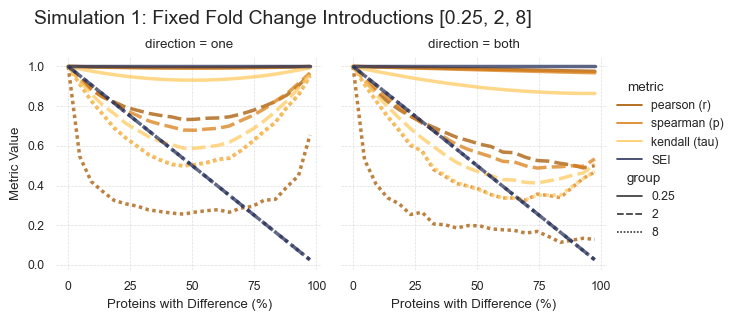

In [13]:
plot_data = sim1_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Plot the figure with relplot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
    
)
# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Metric Value",
    # title="Random Placement of Fixed Fold Changes additions ",
)
g.fig.suptitle(
    f"Simulation 1: Fixed Fold Change Introductions {groups}",
    x=0.4,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)


# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_1_LinePlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

There are many interesting things I can see from this plot:
1. If change introduced in one direction the correlation coefficient will increase after half of the proteins are changed, meaning the pattern of the data is changed and moving towards the direction of the difference. However the SEI is not effected by the direction of the difference, since it is calculated on the significantly equivalent proteins.
2. The increased magnitude makes the correlation coefficient dip lower however the SEI is not effected by the magnitude of the difference, as long as the difference is significant based on the equivalence boundary.
3. The magnitude that is below the equivalence boundary will not be captured by the SEI, however the correlation coefficient will capture the difference if the magnitude is large enough.
4. The kendall correlation coefficient is more sensitive to the difference than the pearson correlation coefficient, which is expected since kendall correlation coefficient is a non-parametric measure of correlation.
5. The pearson correlation is effected by the magnitude more than rank-based spearman and kendall correlation coefficients.

---


Considering the observable ground truth is the diagnoal from 0,1 to 100, 0 we can see the equivalence percent follows the ground truth better than the correlation coefficient. However an alternative to plot this data is to plot the difference between the metric and the ground truth, this way we can see how much the metric is deviating from the ground truth.

The deviation from the ground truth is calculated as `metric - ground_truth` and plotted as a line plot. The x-axis will be the percentage of proteins the difference is added and the y-axis will be the deviation from the ground truth. The line plot will have 12 lines, 4 colors for each metric and 3 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

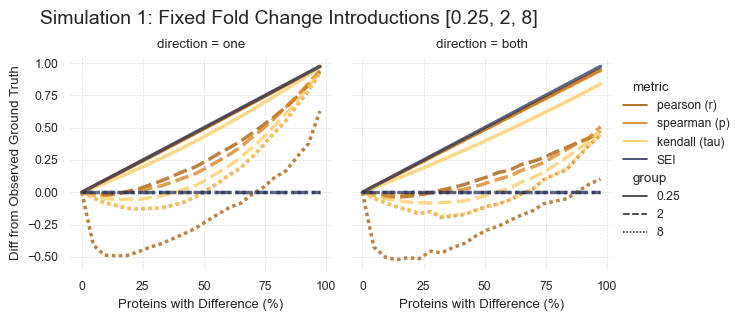

In [14]:
tmp_data =  sim1_data.copy()
for k,v in metric_colors.items():
    if k == "baseline":
        continue    

    tmp_data[k] = tmp_data[k] - tmp_data["obs_ground_truth"]

plot_data = tmp_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation",
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Create a line plot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Diff from Observed Ground Truth",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 1: Fixed Fold Change Introductions {groups}",
    x=0.4,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

# Despine
sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_1_LinePlot_Diff",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

We can see the correlation first shows lower than ground truth until 50% then starts to overestimate the similarity between the two samples, since the pattern of the data is changed and moving towards the direction of the difference. However the SEI is not effected by the direction of the difference, since it is calculated on the significantly equivalent proteins. The magnitude of the difference effects the correlation coefficient but not the SEI a much as long as the difference is beyond the equivalence boundary, in the case of 0.25 the correlation coefficient and correlation is showing high similarity across the board.

## Scenario 2: Introducing a Random Fold-Change within a Range in One and Both Directions

The second scenario is very similar to first one, but instead of introducing a fixed fold-change the difference will be introduced as a random fold-change within a range. Similarly in two versions, where the fold-change introduced in one direction and both directions. The ranges that I will use are `0.25-0.75, 1-3, 4-12`.

In the previous scenario I've seen the magnitude of the difference effects the correlation coefficient but not the SEI. I've also seen that if a difference is introduced in one direction the correlation increases after half of the proteins are changed, meaning the pattern of the data is changed and moving towards the direction of the difference. However the SEI is not effected by the direction of the difference, since it is calculated on the significantly equivalent proteins.

Here are the things I am interested in seeing in this scenario:
- How the range of the difference have effect on single and both direction differences

### Initialize Iterations to Run

In [15]:
results_data = pd.DataFrame()
s1_arr = sim_data[S1].values
s2_arr = sim_data[S2].values
total_proteins = s1_arr.shape[0]
s1_cols = [S1 + "_" + str(x) for x in range(1, n_rep+1)]
s2_cols = [S2 + "_" + str(x) for x in range(1, n_rep+1)]

directions = ["one", "both"]
groups = [
    (0.25, 0.75), 
    (1, 3), 
    (4, 12)
]
snapshot_group = (1, 3)
iterations = []
for i in custom_range:
    for j in directions:
        for k in groups:
            iterations.append([
                i,  # Number of proteins to change
                j,  # Direction
                k   # Fold-change ranges
            ])
print(f"Total iterations to run: {len(iterations)}")

Total iterations to run: 132


### Running the Simulation and Plotting the Line Plot

Because I usually have to run over more than 100 simulations I will put the code that creates simulated data, runs the metrics, creates snapshots plots and creates all the results as a table into a function that can be run over multiple-cores to speed up the process.

The results will be presented as a line plot with the percentage of proteins the difference is added on the x-axis and the metric's value from 0 to 1 on the y-axis. The line plot will have 12 lines, 4 colors for each metric and 3 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

The baseline will be a diagonal line in decreaing order from 1 to 0. 

In [16]:
# The function to run over multiple-cores
def run_simulation_two(cur_iter):
    cur_s1_arr = s1_arr.copy()
    cur_s2_arr = s2_arr.copy()
    cur_name = f"Prot-{cur_iter[0]}_Dir-{cur_iter[1]}_Grp-{cur_iter[2][0]}to{cur_iter[2][1]}"
    # Get the number of proteins to change
    n_proteins = cur_iter[0]
    # Calculate reference similarity
    baseline = 1 - (n_proteins / total_proteins)
    # Get the direction
    cur_direction = cur_iter[1]
    # Get the fold change range
    cur_group = cur_iter[2]

    # Get the indexes to change
    idxs = np.random.choice(
        total_proteins, 
        n_proteins, 
        replace=False
    )
    if cur_direction == "both":
        # Get the fold change values
        dir = np.random.choice(
            [-1, 1], 
            n_proteins, 
            replace=True
        )
        fc_vals = dir * np.random.uniform(
            cur_group[0], 
            cur_group[1], 
            n_proteins
        )
    else:
        fc_vals = 1 * np.random.uniform(
            cur_group[0], 
            cur_group[1], 
            n_proteins
        )

    # Change the values
    cur_s2_arr[idxs] = cur_s2_arr[idxs] + fc_vals

    # Create a dataframe with the replicated data
    cur_data = pd.concat(
        [
            pd.DataFrame(
                np.tile(cur_s1_arr, (n_rep, 1)).T,
                columns=s1_cols
            ),
            pd.DataFrame(
                np.tile(cur_s2_arr, (n_rep, 1)).T,
                columns=s2_cols
            )
        ],
        axis=1
    )

    # Store the data at the custom moments
    if n_proteins in percentile_vals:
        if cur_group == snapshot_group:
            plots.scatterplot_annotated_comparison(
                data = cur_data,
                s1_cols = s1_cols,
                s2_cols = s2_cols,
                baseline = baseline,
                # Used to calculate the equivalence percent value
                pThr = pThr,
                eqThr = eqThr,

                figsize = (5, 5),
                xlabel = f"{S1} (log2)",
                ylabel = f"{S2} (log2)",
                title = f"Snapshot Comparison -> ({cur_name})",
                title_fontsize=14,
                point_size = 25,
                save = True,
                filepath = fig_path,
                fileformat = figure_formats,
                filename = f"RangeFC_{cur_name}_Snapshot",
                dont_show = True
            )    

    # Collect and store metrics
    res = utils.collect_metrics(
        cur_data,
        cur_data.columns[:n_rep],
        cur_data.columns[n_rep:],
        pThr=pThr,
        eqThr=eqThr,
    )
    res["obs_ground_truth"] = baseline
    res["changed_prots_pct"] = n_proteins / total_proteins * 100
    res["direction"] = cur_direction
    res["group"] = cur_group
    res["simulation"] = 2

    return pd.Series(res)

# Run the simulation
with Pool(30) as p:
    results_data = p.map(run_simulation_two, iterations)

sim2_data = pd.concat(results_data, axis=1).T.sort_values(
    [
        "group", "direction", "changed_prots_pct"
    ], 
    ascending=[True, False, True]
).reset_index(drop=True)

# Save the data
sim2_data.to_csv(
    f"{output_path}Simulation2_Data.csv",
    index=False
)

# Add the sim data to the simulation results
simulation_results_data = pd.concat(
    [
        simulation_results_data,
        sim2_data
    ],
    axis=0,
    ignore_index=True
)

print(f"Simulation 2: {sim2_data.shape}")
sim2_data.head()

Simulation 2: (132, 9)


,pearson (r),spearman (p),kendall (tau),SEI,obs_ground_truth,changed_prots_pct,direction,group,simulation
0,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,one,"(0.25, 0.75)",2
1,0.9951,0.9937,0.9758,0.9781,0.9536,4.6391,one,"(0.25, 0.75)",2
2,0.9906,0.9880,0.9533,0.9551,0.9072,9.2782,one,"(0.25, 0.75)",2
3,0.9865,0.9830,0.9332,0.9308,0.8608,13.9172,one,"(0.25, 0.75)",2
4,0.9828,0.9783,0.9146,0.9076,0.8144,18.5563,one,"(0.25, 0.75)",2


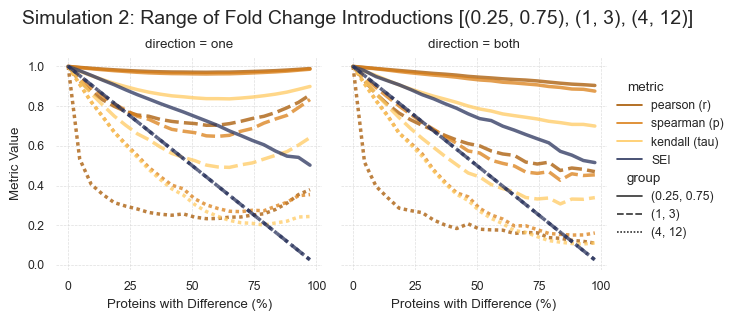

In [17]:
plot_data = sim2_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Plot the figure with relplot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
    
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Metric Value",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 2: Range of Fold Change Introductions {groups}",
    x=0.5,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_2_LinePlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The same observations from the previous scenario applies here as well, however the random fold-change difference within a range is more of a realistic than the fixed fold-change difference. The first fc range group is the most interesting one, half of the range is below the quivalence boundary where it won't recognize the difference and still count them as equivalent, where the other half is above the equivalence boundary where it will recognize the difference and count them as not equivalent. That's why the SEI is halfway towards the true baseline, while the correlation coefficients are shows higher correlation equivalence percent. However when the the fc magnitude increased as we've seen in the previous scenario the correlation coefficient dips lower and lower.

---

The deviation from the ground truth is calculated as `metric - ground_truth` and plotted as a line plot. The x-axis will be the percentage of proteins the difference is added and the y-axis will be the deviation from the ground truth. The line plot will have 12 lines, 4 colors for each metric and 3 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

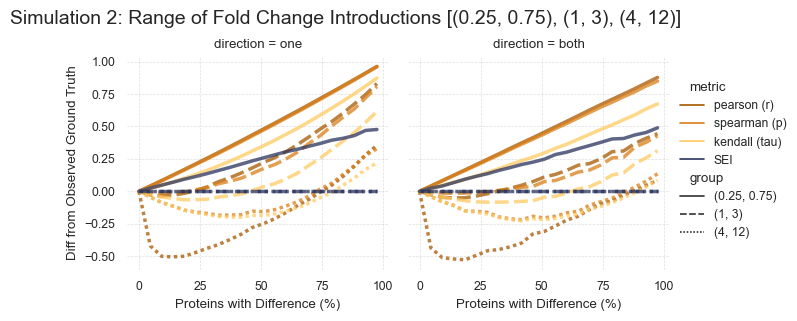

In [18]:
tmp_data =  sim2_data.copy()
for k,v in metric_colors.items():
    if k == "baseline":
        continue    

    tmp_data[k] = tmp_data[k] - tmp_data["obs_ground_truth"]

plot_data = tmp_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation",
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Create a line plot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Diff from Observed Ground Truth",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 2: Range of Fold Change Introductions {groups}",
    x=0.4,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

# Despine
sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_2_LinePlot_Diff",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )




## Scenario 3: Effect of Replicate Variance on the Metrics

For this scenario I will use a slightly different approach, instead of introducing different differences and see how the metrics respond to them, I will use range (1, 3) to introduce in both directions, and see how the metrics respond to the increasing replicate variance. In this case, i will have increased within-replicate variance instead of perfect replicates as used in the previous scenarios.

First need to explore the intra-sample CV distribution from a real sample, to mimic the distribution in the simulated data.

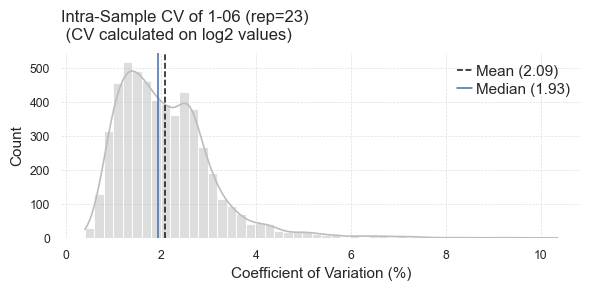

In [19]:
fig, ax = plt.subplots(
    figsize=(6, 3)
)
cv_dist = utils.cv_numpy(
        np.log2(S1_data.values),
        ignore_nan=True
    )
sns.histplot(
    cv_dist,
    ax = ax,
    color = metric_colors["baseline"],
    bins = 50,
    kde = True,
    # stat = "density",
    # common_norm = False,
    # cumulative = False,
)

# Add a line for mean and median values
ax.axvline(
    x = np.mean(cv_dist),
    color = 'k',
    linestyle = "--",
    linewidth = 1.15, 
    label = f"Mean ({np.mean(cv_dist):.2f})"
)

ax.axvline(
    x = np.median(cv_dist),
    color = 'b',
    linestyle = "-",
    linewidth = 1.15,
    label = f"Median ({np.median(cv_dist):.2f})"
)

# Add legend
ax.legend(
    loc = "upper right",
    frameon = False,
    fontsize = 11,
    handlelength = 1,
    handletextpad = 0.25,
    borderpad = 0.25,
    labelspacing = 0.25
)

ax.set_xlabel(
    "Coefficient of Variation (%)",
    fontsize = 11
)

ax.set_ylabel(
    "Count",
    fontsize = 11
)

ax.set_title(
    "Intra-Sample CV of 1-06 (rep=23) \n (CV calculated on log2 values)",
    fontsize = 12,
    loc = "left",
    pad = 10,
)

ax.grid(
    axis = "both",
    color = "lightgray",
    alpha = 0.75,
    linestyle = "--",
    linewidth = 0.5
)

sns.despine(
    left = True,
    bottom = True
)

plt.tight_layout()

It is a bit weird since most of the time it is a skewed distribution, but this one has a weird bump around 50%cv, likely the effect of spike-ins. However I will use this distribution to mimic the intra-sample variation in the simulated data.

> **Note:** I usually recommend to calculate the CVs on non-log2 scaled data, but here for the sake of simplicity in the simulation I will use the CVs calculated on log2 scaled data. However the use of log2 doesn't effect the spread only effects the mean, median, etc, as long as the CVs introduced in the simulation are on the same scale no confounding effect will be introduced.


With this scenarious I want to see how the metrics respond to the increasing intra-sample variation. Let's get to it. I will test the performance with 5 different mean intra-sample CVs 1, 2, 4, 8, 16, where 16%CV on log2 is a huge variation, and from the reference between 1 to 4 is to expect.

### Initialize Iterations to Run

In [20]:
results_data = pd.DataFrame()
s1_arr = sim_data[S1].values
s2_arr = sim_data[S2].values
total_proteins = s1_arr.shape[0]
s1_cols = [S1 + "_" + str(x) for x in range(1, n_rep+1)]
s2_cols = [S2 + "_" + str(x) for x in range(1, n_rep+1)]

directions = ["one", "both"]
# groups = [1, 2, 4, 8, 16]
groups = [1, 4, 16]
snapshot_group = 4
iterations = []
for i in custom_range:
    for j in directions:
        for k in groups:
            iterations.append([
                i,  # Number of proteins to change
                j,  # Direction
                k   # Fold-change ranges
            ])
print(f"Total iterations to run: {len(iterations)}")

Total iterations to run: 132


In [21]:
# Function to run over multiple cores
def run_simulation_three(cur_iter):
    cur_s1_arr = s1_arr.copy()
    cur_s2_arr = s2_arr.copy()
    cur_name = f"Prot-{cur_iter[0]}_Dir-{cur_iter[1]}_CV-{cur_iter[2]}"
    # Get the number of proteins to change
    n_proteins = cur_iter[0]
    # Calculate reference similarity
    baseline = 1 - (n_proteins / total_proteins)
    # Get the direction
    cur_direction = cur_iter[1]
    # Get the CV range
    cur_group = cur_iter[2]
    
    # Get the indexes to change
    idxs = np.random.choice(
        total_proteins, 
        n_proteins, 
        replace=False
    )

    if cur_direction == "both":
        dir = np.random.choice(
            [-1, 1], 
            n_proteins, 
            replace=True
        )
        # Pick from 1-3
        fc_vals = dir * np.random.uniform(
            1, 
            3, 
            n_proteins
        )
    else:
        fc_vals = 1 * np.random.uniform(
            1, 
            3, 
            n_proteins
        )

    # Update the values
    cur_s2_arr[idxs] = cur_s2_arr[idxs] + fc_vals

    # Create a cv-dist for the current data
    cur_cv_dist = np.random.gamma(
        2,
        1,
        total_proteins
    )
    cur_cv_dist = cur_cv_dist * cur_group / np.mean(cur_cv_dist)
    cur_cv_dist = cur_cv_dist - np.min(cur_cv_dist) + 1

    # Build replicate data for the current sample
    sd_s1_arr = cur_s1_arr * cur_cv_dist / 100
    sd_s2_arr = cur_s2_arr * cur_cv_dist / 100

    table1 = np.random.uniform(
        low=1, 
        high=0.1, 
        size=(total_proteins, n_rep)
    )
    table1 = table1 * sd_s1_arr[:, np.newaxis] + cur_s1_arr[:, np.newaxis]
    
    table2 = np.random.uniform(
        low=1, 
        high=0.1, 
        size=(total_proteins, n_rep)
    )
    table2 = table2 * sd_s2_arr[:, np.newaxis] + cur_s2_arr[:, np.newaxis]

    # Create a dataframe with the replicated data
    cur_data = pd.concat(
        [
            pd.DataFrame(
                table1,
                columns=s1_cols
            ),
            pd.DataFrame(
                table2,
                columns=s2_cols
            )
        ],
        axis=1
    )

    # Store the data at the custom moments
    if n_proteins in percentile_vals:
        if cur_group == snapshot_group:
            plots.scatterplot_annotated_comparison(
                data = cur_data,
                s1_cols = s1_cols,
                s2_cols = s2_cols,
                baseline = baseline,
                # Used to calculate the equivalence percent value
                pThr = pThr,
                eqThr = eqThr,

                figsize = (5, 5),
                xlabel = f"{S1} (log2)",
                ylabel = f"{S2} (log2)",
                title = f"Snapshot Comparison -> ({cur_name})",
                title_fontsize=14,
                point_size = 25,
                save = True,
                filepath = fig_path,
                fileformat = figure_formats,
                filename = f"CV_{cur_name}_Snapshot",
                dont_show = True
            )

    # Collect and store metrics
    res = utils.collect_metrics(
        cur_data,
        cur_data.columns[:n_rep],
        cur_data.columns[n_rep:],
        pThr=pThr,
        eqThr=eqThr,
    )

    res["obs_ground_truth"] = baseline
    res["changed_prots_pct"] = n_proteins / total_proteins * 100
    res["direction"] = cur_direction
    res["group"] = cur_group
    res["simulation"] = 3

    return pd.Series(res)

# Run the simulation
with Pool(30) as p:
    results_data = p.map(run_simulation_three, iterations)

sim3_data = pd.concat(results_data, axis=1).T.sort_values(
    [
        "group", "direction", "changed_prots_pct"
    ], 
    ascending=[True, False, True]
).reset_index(drop=True)

# Save the data
sim3_data.to_csv(
    f"{output_path}Simulation3_Data.csv",
    index=False
)

# Add the sim data to the simulation results
simulation_results_data = pd.concat(
    [
        simulation_results_data,
        sim3_data
    ],
    axis=0,
    ignore_index=True
)

print(f"Simulation 3: {sim3_data.shape}")
sim3_data.head()

Simulation 3: (132, 9)


,pearson (r),spearman (p),kendall (tau),SEI,obs_ground_truth,changed_prots_pct,direction,group,simulation
0,0.9915,0.9895,0.9138,1.0000,1.0000,0.0000,one,1,3
1,0.9219,0.9361,0.8515,0.9536,0.9536,4.6391,one,1,3
2,0.8684,0.8850,0.7917,0.9072,0.9072,9.2782,one,1,3
3,0.8282,0.8432,0.7408,0.8608,0.8608,13.9172,one,1,3
4,0.7937,0.8018,0.6912,0.8144,0.8144,18.5563,one,1,3


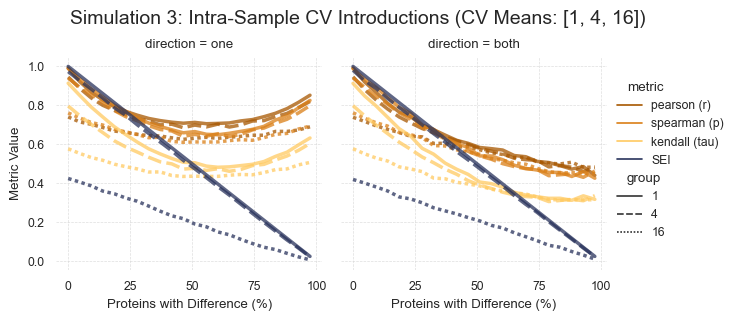

In [22]:
plot_data = sim3_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Plot the figure with relplot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
    
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Metric Value",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 3: Intra-Sample CV Introductions (CV Means: {groups})",
    x=0.5,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_3_LinePlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The introducing intra-sample CV is different from other scenarious, since the variation between replicates are not introduced in them. However in reality the run to run variation is a reality in proteomics and it is important to see how the metrics respond to it. 

As expected with larger variation between the replicates the SEI is effected the most. This is due to it is being based on statistical testing, a lot of actual equivalent proteins are not called equivalent due to the increased variation. On the other hand the effect of CV is not pronounced in correlation coefficient, since it is a measure of linear relationship between two variables, and the variation between replicates doesn't effect the linear relationship between two variables. This is where the correlation is more robust, but it is still not able to capture the decreasing similarity since after 50% of the proteins are changed the relationship between two variables is changed but correlation moves towards higher values again, especially in single direction difference.

---

The deviation from the ground truth is calculated as `metric - ground_truth` and plotted as a line plot. The x-axis will be the percentage of proteins the difference is added and the y-axis will be the deviation from the ground truth. The line plot will have 12 lines, 4 colors for each metric and 3 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

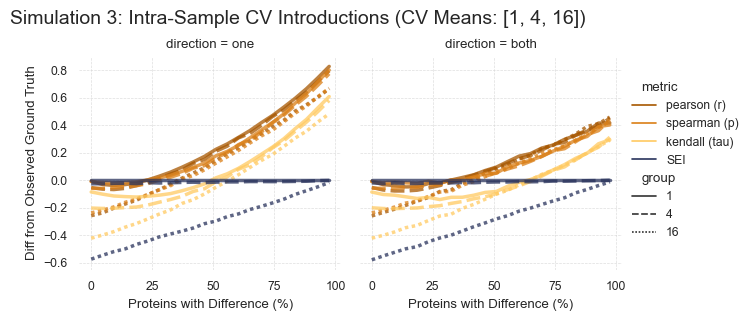

In [23]:
tmp_data =  sim3_data.copy()
for k,v in metric_colors.items():
    if k == "baseline":
        continue    

    tmp_data[k] = tmp_data[k] - tmp_data["obs_ground_truth"]

plot_data = tmp_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation",
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Create a line plot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Diff from Observed Ground Truth",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 3: Intra-Sample CV Introductions (CV Means: {groups})",
    x=0.4,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
g.axes[0, 1].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)

# Despine
sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_3_LinePlot_Diff",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )



## Scenario 4: Replacing Second Sample with Random Values

In the previous scenarious we modify the second sample with some fold-changes and see how the metrics respond to it. Obviously since the changes are based on a already established relationship it was favoring the correlation coefficient. In this scenario I will replace the second sample with random values and see how the metrics respond to it and if the SEI is able to capture the difference in a more robust way.

With this scenario I want to see how the metrics respond to the random values introduced to the second sample. I will simply resample the values already exists in the first sample and replace the second sample with it. There will be single lines.

In [24]:
results_data = pd.DataFrame()
s1_arr = sim_data[S1].values
s2_arr = sim_data[S2].values
total_proteins = s1_arr.shape[0]
s1_cols = [S1 + "_" + str(x) for x in range(1, n_rep+1)]
s2_cols = [S2 + "_" + str(x) for x in range(1, n_rep+1)]

# groups = range(1, 11) # 10 Iterations
groups = [0.5, 1, 2]
iterations = []
for i in custom_range:
    for j in groups:
        iterations.append([
            i,  # Number of proteins to change
            j   # Intensity Scaler
        ])
print(f"Total iterations to run: {len(iterations)}")

Total iterations to run: 66


In [25]:
# Function to run over multiple cores
def run_simulation_four(cur_iter):
    cur_s1_arr = s1_arr.copy()
    cur_s2_arr = s2_arr.copy()
    cur_name = f"Prot-{cur_iter[0]}_Grp-{cur_iter[1]}"
    # Get the number of proteins to change
    n_proteins = cur_iter[0]
    # Calculate reference similarity
    baseline = 1 - (n_proteins / total_proteins)
    cur_group = cur_iter[1]

    # Get the indexes to change
    idxs = np.random.choice(
        total_proteins, 
        n_proteins, 
        replace=False
    )
    # # Randomly sample from the current S1 data use select
    # cur_s2_arr[idxs] = np.random.choice(
    #     cur_s1_arr,
    #     size=n_proteins
    # )

    # Sample from cur_s1_arr
    cur_s2_arr[idxs] = np.random.uniform(
        low=np.min(cur_s1_arr) * cur_group,
        high=np.max(cur_s1_arr) * cur_group,
        size=n_proteins
    ) 
    

    # Create a dataframe with the replicated data
    cur_data = pd.concat(
        [
            pd.DataFrame(
                np.tile(cur_s1_arr, (n_rep, 1)).T,
                columns=s1_cols
            ),
            pd.DataFrame(
                np.tile(cur_s2_arr, (n_rep, 1)).T,
                columns=s2_cols
            )
        ],
        axis=1
    )

    # Store the data at the custom moments
    if n_proteins in percentile_vals:
        if cur_group == 1:
            plots.scatterplot_annotated_comparison(
                data = cur_data,
                s1_cols = s1_cols,
                s2_cols = s2_cols,
                baseline = baseline,
                # Used to calculate the equivalence percent value
                pThr = pThr,
                eqThr = eqThr,

                figsize = (5, 5),
                xlabel = f"{S1} (log2)",
                ylabel = f"{S2} (log2)",
                title = f"Snapshot Comparison -> ({cur_name})",
                title_fontsize=14,
                point_size = 25,
                save = True,
                filepath = fig_path,
                fileformat = figure_formats,
                filename = f"Random_{cur_name}_Snapshot",
                dont_show = True
            )

    # Collect and store metrics
    res = utils.collect_metrics(
        cur_data,
        cur_data.columns[:n_rep],
        cur_data.columns[n_rep:],
        pThr=pThr,
        eqThr=eqThr,
    )

    res["obs_ground_truth"] = baseline
    res["changed_prots_pct"] = n_proteins / total_proteins * 100
    res["direction"] = "random"
    res["group"] = cur_group
    res["simulation"] = 4

    return pd.Series(res)

# Run the simulation
with Pool(30) as p:
    results_data = p.map(run_simulation_four, iterations)

sim4_data = pd.concat(results_data, axis=1).T.sort_values(
    [
        "group", "direction", "changed_prots_pct"
    ], 
    ascending=[True, False, True]
).reset_index(drop=True)

# Save the data
sim4_data.to_csv(
    f"{output_path}Simulation4_Data.csv",
    index=False
)

# Add the sim data to the simulation results
simulation_results_data = pd.concat(
    [
        simulation_results_data,
        sim4_data
    ],
    axis=0,
    ignore_index=True
)

print(f"Simulation 4: {sim4_data.shape}")
sim4_data.head()

Simulation 4: (66, 9)


,pearson (r),spearman (p),kendall (tau),SEI,obs_ground_truth,changed_prots_pct,direction,group,simulation
0,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,random,0.5000,4
1,0.4769,0.9083,0.9092,0.9536,0.9536,4.6391,random,0.5000,4
2,0.3603,0.8276,0.8263,0.9072,0.9072,9.2782,random,0.5000,4
3,0.2836,0.7416,0.7419,0.8608,0.8608,13.9172,random,0.5000,4
4,0.2550,0.6703,0.6689,0.8144,0.8144,18.5563,random,0.5000,4


In [26]:
# Save the simulation results data as supplementary data
simulation_results_data.to_csv(
    f"{supp_path}table_s3_1.csv",
    index=False
)

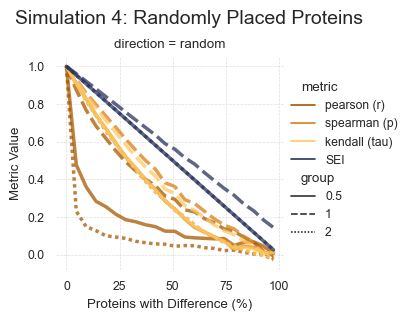

In [27]:
plot_data = sim4_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Plot the figure with relplot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
    
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Metric Value",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 4: Randomly Placed Proteins",
    x=0.5,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
# g.axes[0, 1].grid(
#     axis="both",
#     color="lightgray",
#     alpha=0.75,
#     linestyle="--",
#     linewidth=0.5,
# )

sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_4_LinePlot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

The last scenario is replacing the second sample with uniformly distributed random values that are within the same range as the first sample (min-max). This is the truly the random scenario, where the correlation coefficient is more strinct and overall gets lower values then the observeable ground truth, where the equivalence percent's precision is shown here, where it is able to capture the differences where it applies. However the equivalence percent doesn't fully align with the observeable ground truth, since the some of the random values by chance can be within the equivalence boundary and counted as equivalent even though they are replaced with random values. 

---

The deviation from the ground truth is calculated as `metric - ground_truth` and plotted as a line plot. The x-axis will be the percentage of proteins the difference is added and the y-axis will be the deviation from the ground truth. The line plot will have 4 lines, 4 colors for each metric and 1 linestyles for each difference magnitude. The difference direction will be represented as a facet (left and right).

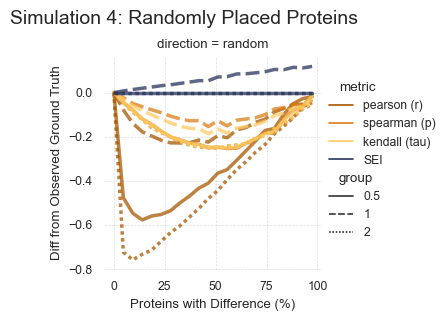

In [28]:
tmp_data =  sim4_data.copy()
for k,v in metric_colors.items():
    if k == "baseline":
        continue    

    tmp_data[k] = tmp_data[k] - tmp_data["obs_ground_truth"]

plot_data = tmp_data.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation",
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

# Create a line plot
g = sns.relplot(
    kind="line",

    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    col="direction",
    
    data=plot_data,
    
    # Style
    height=3,
    aspect=1.05,
    linewidth=2.5,
    alpha=0.75,
    palette=metric_colors,
    legend="full",
)

# Clean up the plot
g.set(
    xlabel="Proteins with Difference (%)",
    ylabel="Diff from Observed Ground Truth",
    # title="Random Placement of Fixed Fold Changes additions ",
)

g.fig.suptitle(
    f"Simulation 4: Randomly Placed Proteins",
    x=0.4,
    y=1.05,
    fontsize=14,
    # fontweight="bold",
)

# Xticks to percentage 0-100 25% steps
g.axes[0, 0].set_xticks(
    np.arange(
        0, 
        101, 
        25
    ),
    minor=False,
)

# Add grid
g.axes[0, 0].grid(
    axis="both",
    color="lightgray",
    alpha=0.75,
    linestyle="--",
    linewidth=0.5,
)
# g.axes[0, 1].grid(
#     axis="both",
#     color="lightgray",
#     alpha=0.75,
#     linestyle="--",
#     linewidth=0.5,
# )

# Despine
sns.despine(
    left=True,
    bottom=True,
)

fig.tight_layout()

# Save the figure
# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Simulation_4_LinePlot_Diff",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )



## Build Main Figure

In the main figure I want to highlight the one and both directions of simulation 2, both direction of simulation 3, and the simulation 4 line graphs as 2x2 grid.

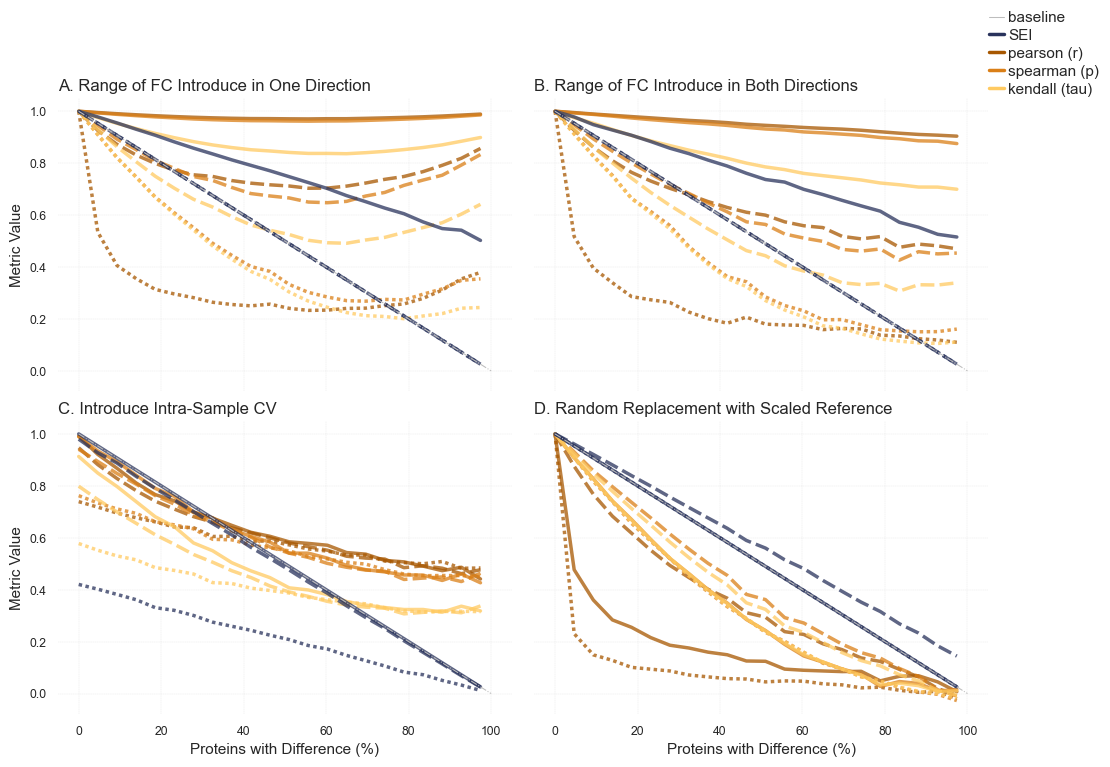

In [29]:
# Get the 2, 3, 4 simulations' data
subset = simulation_results_data[simulation_results_data["simulation"].isin([2, 3, 4])]
# Remove one direction from simulation 3
subset = subset[~((subset["simulation"] == 3) & (subset["direction"] == "one"))]
# Melting the data
plot_data = subset.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

fig, ax = plt.subplots(
    figsize=(12, 8),
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.1, "wspace": 0.05}
)

# Plot the data simulation 2 direction one 
cur_plot_data = plot_data[
    (plot_data["simulation"] == 2) & (plot_data["direction"] == "one")
]
sns.lineplot(
    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    data=cur_plot_data,
    ax=ax[0, 0],
    palette=metric_colors,
    linewidth=2.5,
    alpha=0.75,
    legend=False
)

ax[0, 0].set_title(
    "A. Range of FC Introduce in One Direction",
    fontsize=12,
    # fontweight="bold",
    loc="left",
    pad=5,

)

# Plot the data simulation 2 direction both
cur_plot_data = plot_data[
    (plot_data["simulation"] == 2) & (plot_data["direction"] == "both")
]
sns.lineplot(
    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    data=cur_plot_data,
    ax=ax[0, 1],
    palette=metric_colors,
    linewidth=2.5,
    alpha=0.75,
    legend=False
)

ax[0, 1].set_title(
    "B. Range of FC Introduce in Both Directions",
    fontsize=12,
    # fontweight="bold",
    loc="left",
    pad=5,
)

# Plot the data simulation 3 direction both
cur_plot_data = plot_data[
    (plot_data["simulation"] == 3) & (plot_data["direction"] == "both")
]
sns.lineplot(
    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    data=cur_plot_data,
    ax=ax[1, 0],
    palette=metric_colors,
    linewidth=2.5,
    alpha=0.75,
    legend=False
)

ax[1, 0].set_title(
    "C. Introduce Intra-Sample CV",
    fontsize=12,
    # fontweight="bold",
    loc="left",
    pad=5,
)

# Plot the data simulation 4 direction random
cur_plot_data = plot_data[
    (plot_data["simulation"] == 4) & (plot_data["direction"] == "random")
]
sns.lineplot(
    x="changed_prots_pct",
    y="value",
    hue="metric",
    style="group",
    data=cur_plot_data,
    ax=ax[1, 1],
    palette=metric_colors,
    linewidth=2.5,
    alpha=0.75,
    legend=False
)

ax[1, 1].set_title(
    "D. Random Replacement with Scaled Reference",
    fontsize=12,
    # fontweight="bold",
    loc="left",
    pad=5,
)

# Add Styling
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel(
            "Proteins with Difference (%)",
            fontsize=11
        )
        ax[i, j].set_ylabel(
            "Metric Value",
            fontsize=11
        )
        ax[i, j].grid(
            axis="both",
            color="lightgray",
            alpha=0.75,
            linestyle="--",
            linewidth=0.25
        )
        
        ax[i, j].plot(
            [0, 100],
            [1, 0],
            color=metric_colors["baseline"],
            linestyle="dashdot",
            linewidth=.75,
            # zorder=0
        )

# Build legend handles from metric_colors dict
handles = []
for k,v in metric_colors.items():
    cur_linestyle = "-"
    cur_inewidth = 2.5
    if k == "baseline":
        cur_linestyle = "--"
        cur_inewidth = 0.75

    handles.append(
        plt.Line2D(
            [0], 
            [0], 
            color=v, 
            linewidth=cur_inewidth,
            label=k
        )
    )

# Add legend
fig.legend(
    handles=handles,
    labels=list(metric_colors.keys()),
    loc="upper right",
    frameon=False,
    fontsize=11,
    handlelength=1,
    handletextpad=0.25,
    borderpad=0.25,
    labelspacing=0.25
)



sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "simulaton_combined_lineplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

### Alternative Split Each to Subsets with 3x3 Grid

Another alternative I can do for the main figure is to instead split the different line styles into different subplots, and only keeping simulation 2 both directions, simulation 3 both directions, and simulation 4 in the main figure. This way I can show the effect of different line styles in the same plot, and the effect of different scenarios in the same plot. I will draw the abline to show the observeable ground truth in each subplot. and they won't be mashed up in the same plot.

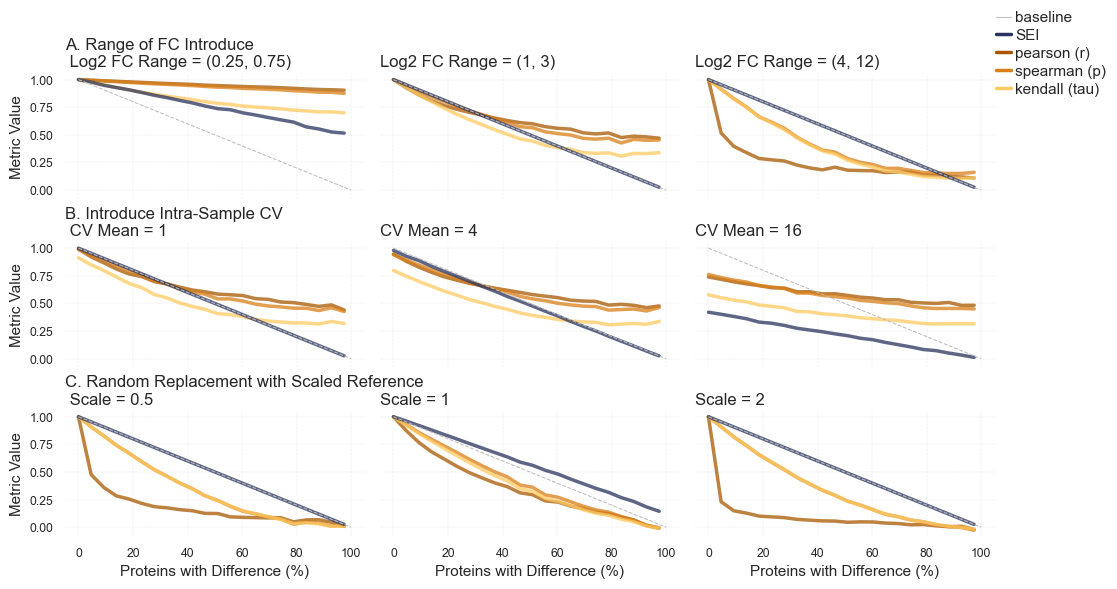

In [30]:
# Get the 2, 3, 4 simulations' data
subset = simulation_results_data[
    simulation_results_data["simulation"].isin([2, 3, 4]) & 
    (simulation_results_data["direction"] != "one")
]
# Melting the data
plot_data = subset.melt(
    id_vars=[
        "changed_prots_pct", 
        "direction", 
        "group", 
        "simulation", 
        "obs_ground_truth"
    ],
    var_name="metric",
    value_name="value"
)

fig, ax = plt.subplots(
    figsize=(12, 6),
    nrows=3,
    ncols=3,
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.35, "wspace": 0.05}
)

# Plot the data simulation 2 direction both
cur_sim_data = plot_data[
    (plot_data["simulation"] == 2)
]
for i, group in enumerate(cur_sim_data["group"].unique()):
    sns.lineplot(
        x="changed_prots_pct",
        y="value",
        hue="metric",
        data=cur_sim_data[cur_sim_data["group"] == group],
        ax=ax[0, i],
        palette=metric_colors,
        linewidth=2.5,
        alpha=0.75,
        legend=False
    )

    if i == 0:
        ax[0, i].set_title(
            f"A. Range of FC Introduce\n Log2 FC Range = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )
    else: 
        ax[0, i].set_title(
            f"\nLog2 FC Range = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )
    
# Plot the data simulation 3 direction both
cur_sim_data = plot_data[
    (plot_data["simulation"] == 3)
]

for i, group in enumerate(cur_sim_data["group"].unique()):
    sns.lineplot(
        x="changed_prots_pct",
        y="value",
        hue="metric",
        data=cur_sim_data[cur_sim_data["group"] == group],
        ax=ax[1, i],
        palette=metric_colors,
        linewidth=2.5,
        alpha=0.75,
        legend=False
    )

    if i == 0:
        ax[1, i].set_title(
            f"B. Introduce Intra-Sample CV\n CV Mean = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )
    else: 
        ax[1, i].set_title(
            f"\nCV Mean = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )
    
# Plot the data simulation 4 direction random
cur_sim_data = plot_data[
    (plot_data["simulation"] == 4)
]

for i, group in enumerate(cur_sim_data["group"].unique()):
    sns.lineplot(
        x="changed_prots_pct",
        y="value",
        hue="metric",
        data=cur_sim_data[cur_sim_data["group"] == group],
        ax=ax[2, i],
        palette=metric_colors,
        linewidth=2.5,
        alpha=0.75,
        legend=False
    )

    if i == 0:
        ax[2, i].set_title(
            f"C. Random Replacement with Scaled Reference\n Scale = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )
    else: 
        ax[2, i].set_title(
            f"\nScale = {group}",
            fontsize=12,
            # fontweight="bold",
            loc="left",
            pad=5,
        )

# Add Styling
for i in range(3):
    for j in range(3):
        ax[i, j].set_xlabel(
            "Proteins with Difference (%)",
            fontsize=11
        )
        ax[i, j].set_ylabel(
            "Metric Value",
            fontsize=11
        )
        ax[i, j].grid(
            axis="both",
            color="lightgray",
            alpha=0.75,
            linestyle="dashdot",
            linewidth=0.25
        )

        # Add abline from 0,1 to 100,0 reverse diagonal
        ax[i, j].plot(
            [0, 100],
            [1, 0],
            color=metric_colors["baseline"],
            linestyle="--",
            linewidth=.75,
            # zorder=0
        )

# Build legend handles from metric_colors dict
handles = []
for k,v in metric_colors.items():
    cur_linestyle = "-"
    cur_inewidth = 2.5
    if k == "baseline":
        cur_linestyle = "--"
        cur_inewidth = 0.75

    handles.append(
        plt.Line2D(
            [0], 
            [0], 
            color=v, 
            linewidth=cur_inewidth,
            label=k
        )
    )


# Add legend
fig.legend(
    handles=handles,
    labels=list(metric_colors.keys()),
    loc="upper right",
    frameon=False,
    fontsize=11,
    handlelength=1,
    handletextpad=0.25,
    borderpad=0.25,
    labelspacing=0.25
)

sns.despine(
    left=True,
    bottom=True
)

plt.tight_layout()

# Save the figure
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "simulaton_combined_lineplot_2",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )



# Conclusion

In this notebook, I've covered some simulated scenarios and compared the correlation coefficient and sample equivalence index (SEI). The correlation coefficient is a measure of linear relationship between two variables, and the equivalence percent is a measure of how many proteins are equivalent between two samples. So correlation is used to simply check the overall pattern of the data, while equivalence percent relaying on the significantly equivalent proteins provides a more detailed and robust similarity measure between two samples.

In the field correlation is used quite a bit to explore a glimpse of sample similarity but it doesn't provide robust and precise means to measure the similarity between two samples. Where correlation shines is when similarity comparison needs to be done between samples that doesn't have same quantification, since statistical testing on those cases won't be valid. However in proteomics the samples are usually quantified in the same run and the similarity comparison is done between the samples that have same quantification. In those cases the SEI is a better choice to measure the similarity between two samples.

In [ ]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - nbStartTime))

Notebook Execution Time: 00h:00m:35s
